# How to Structure from Motion

## Authors: Muneeb Aadil, Sibt Ul Hussain

In [173]:
#loading needed libraries 
import utils as ut 
import SfM as sfmnp

import matplotlib.pyplot as plt 

from mpl_toolkits.mplot3d import Axes3D

import cv2 
import numpy as np 

#auto-reloading external modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Chapter 1. Prerequisites

## 1.1. Transformations

## 1.2. Camera Models 

## 1.3 RANSAC

# Chapter 2. Epipolar Geometry

## 2.0. Reading a pair of images, and comparing SIFT matches

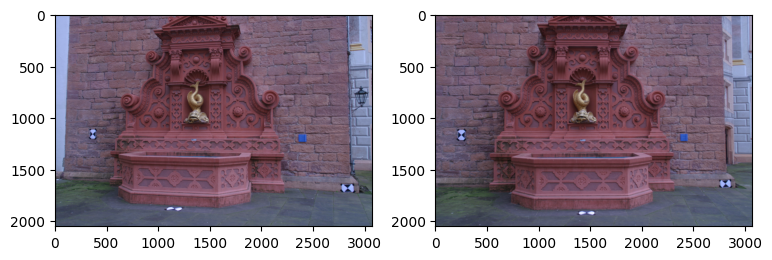

In [174]:
#Reading two images for reference
img1 = cv2.imread("../tutorial/data/fountain-P11/images/0004.jpg")
img2 = cv2.imread("../tutorial/data/fountain-P11/images/0005.jpg")

#Converting from BGR to RGB format
img1 = img1[:,:,::-1]
img2 = img2[:,:,::-1]

#NOTE: you can adjust appropriate figure size according to the size of your screen
fig,ax=plt.subplots(ncols=2,figsize=(9,4)) 
ax[0].imshow(img1)
ax[1].imshow(img2)
plt.show()

In [175]:
#Getting SIFT/SURF features for image matching (this might take a while)
kp1,desc1,kp2,desc2,matches=ut.GetImageMatchesAKAZE(img1,img2)

#Aligning two keypoint vectors
img1pts,img2pts,img1idx,img2idx=ut.GetAlignedMatchesAKAZE(kp1,kp2,matches)


## 2.2. Fundamental Matrix Computation

### 2.2.1. Eight Point Algorithm

In [176]:
F, maskgt= cv2.findFundamentalMat(img1pts,img2pts, method=cv2.FM_8POINT)

print(F)

[[ 5.38037868e-08  8.21470402e-07 -1.07844524e-03]
 [-7.90871373e-07  5.35033723e-07  3.65455253e-03]
 [ 7.31750244e-04 -5.02448081e-03  1.00000000e+00]]


### 2.2.3. with RANSAC (Random Sample Consensus)

In [177]:
F, mask = cv2.findFundamentalMat(img1pts,img2pts,method=cv2.FM_RANSAC,ransacReprojThreshold=0.1)
#mask = maskgt.astype(bool).flatten()

print(F)


[[-3.62415683e-08 -9.70772521e-07  5.74154874e-04]
 [ 1.54388215e-06  3.60683242e-08  5.98262927e-03]
 [-1.07006924e-03 -7.01051263e-03  1.00000000e+00]]


## 2.2. Epipolar Lines Computation

In [178]:
lines2=cv2.computeCorrespondEpilines(img1pts,1,F).reshape(-1,3)
lines1=cv2.computeCorrespondEpilines(img2pts,2,F).reshape(-1,3)


print(lines1)
print(lines2)

[[ 1.60589669e-01 -9.87021255e-01  1.35224600e+03]
 [ 8.73274906e-02 -9.96179657e-01  1.07383744e+03]
 [ 9.06441928e-02 -9.95883342e-01  1.08652862e+03]
 ...
 [-6.03489665e-02 -9.98177340e-01  5.00512930e+02]
 [ 2.10532542e-02 -9.99778356e-01  8.18531712e+02]
 [-7.33878271e-02 -9.97303478e-01  4.49118376e+02]]
[[-1.26787156e-01  9.91929946e-01 -1.43294450e+03]
 [-7.84308384e-02  9.96919557e-01 -1.08729168e+03]
 [-8.04260999e-02  9.96760574e-01 -1.10157846e+03]
 ...
 [-1.13838085e-01  9.93499316e-01 -1.34050626e+03]
 [ 2.79104836e-02  9.99610427e-01 -3.22819791e+02]
 [-9.51335290e-02  9.95464521e-01 -1.20682381e+03]]


## 2.3. Epipoles Computation

In [179]:
#to do later..


## 2.4. Visualizations I: Epipolar Geometry
### 2.4.1. Epipolar Lines

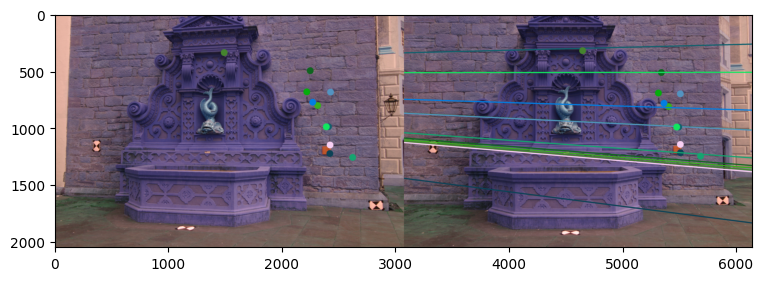

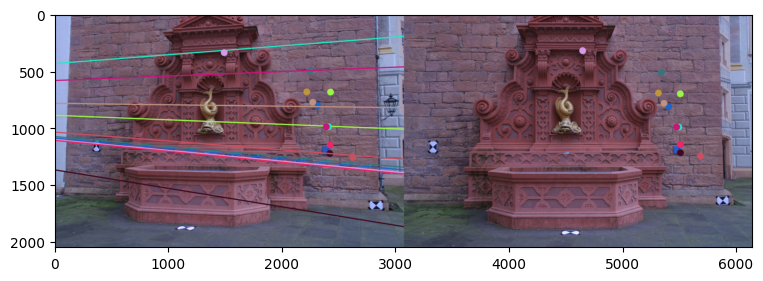

In [180]:

mask=mask.astype(bool).flatten()
tup = ut.drawlines(img2,img1,lines2,img2pts[mask],img1pts[mask],drawOnly=10,
                   linesize=10,circlesize=30)
epilines2 = np.concatenate(tup[::-1],axis=1) #reversing the order of left and right images

# Convert the image from BGR to RGB format
epilines2 = cv2.cvtColor(epilines2, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(9,4))
plt.imshow(epilines2)
plt.show()


tup = ut.drawlines(img1,img2,lines1,img1pts[mask],img2pts[mask],drawOnly=10,
                   linesize=10,circlesize=30)
epilines1 = np.concatenate(tup,axis=1) 

plt.figure(figsize=(9,4))
plt.imshow(epilines1)
plt.show()



### 2.4.2. Epipoles

In [181]:
# to do later..

## 2.5. Pose Estimation

In [182]:
#intrinsic parameter of camera
K = np.array([[2759.48,0,1520.69],[0,2764.16,1006.81],[0,0,1]])

E = K.T.dot(F.dot(K))

R1,R2,t = sfmnp.ExtractCameraPoses(E)
t = t[:,np.newaxis]

## 2.6. Visualizations II: Camera Poses

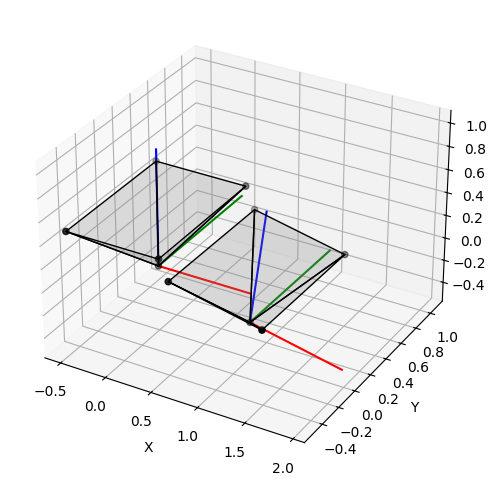

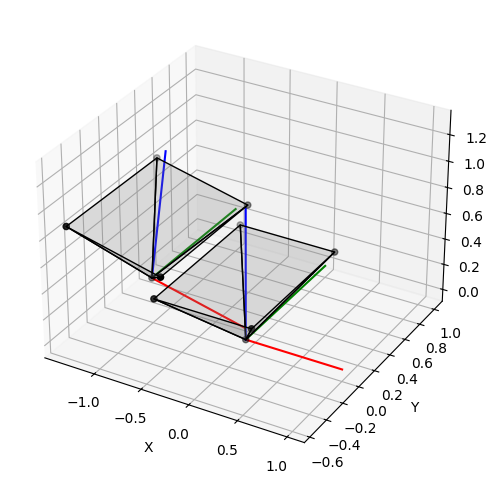

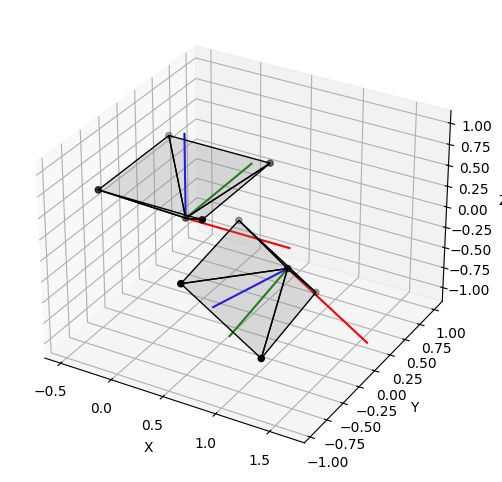

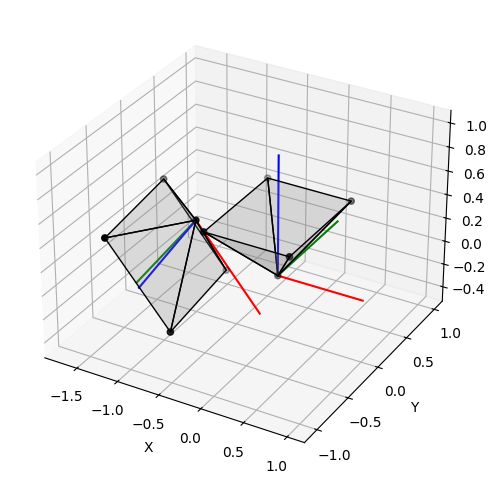

In [183]:
for R_ in [R1,R2]: 
    for t_ in [t,-t]:
        
        fig = plt.figure(figsize=(9,6))
        ax = fig.add_subplot(111, projection='3d')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')

        ut.PlotCamera(np.eye(3,3),np.zeros((3,)),ax)
        ut.PlotCamera(R_,t_[:,0],ax)

# Chapter 3. 3D Scene Estimations

## 3.1. Triangulation: DLT Method 

In [184]:
def GetTriangulatedPts(img1pts,img2pts,K,R,t,triangulateFunc): 
    img1ptsHom = cv2.convertPointsToHomogeneous(img1pts)[:,0,:]
    img2ptsHom = cv2.convertPointsToHomogeneous(img2pts)[:,0,:]

    img1ptsNorm = (np.linalg.inv(K).dot(img1ptsHom.T)).T
    img2ptsNorm = (np.linalg.inv(K).dot(img2ptsHom.T)).T

    img1ptsNorm = cv2.convertPointsFromHomogeneous(img1ptsNorm)[:,0,:]
    img2ptsNorm = cv2.convertPointsFromHomogeneous(img2ptsNorm)[:,0,:]
    
    pts4d = triangulateFunc(np.eye(3,4),np.hstack((R,t)),img1ptsNorm.T,img2ptsNorm.T)
    pts3d = cv2.convertPointsFromHomogeneous(pts4d.T)[:,0,:]
    
    return pts3d

In [185]:
pts3d = GetTriangulatedPts(img1pts[mask],img2pts[mask],K,R2,t,cv2.triangulatePoints)


In [186]:
configSet = [None,None,None,None]
configSet[0] = (R1,t,GetTriangulatedPts(img1pts[mask],img2pts[mask],K,R1,t,cv2.triangulatePoints))
configSet[1] = (R1,-t,GetTriangulatedPts(img1pts[mask],img2pts[mask],K,R1,-t,cv2.triangulatePoints))
configSet[2] = (R2,t,GetTriangulatedPts(img1pts[mask],img2pts[mask],K,R2,t,cv2.triangulatePoints))
configSet[3] = (R2,-t,GetTriangulatedPts(img1pts[mask],img2pts[mask],K,R2,-t,cv2.triangulatePoints))

## 3.2. Visualizing the triangulated points of configurations

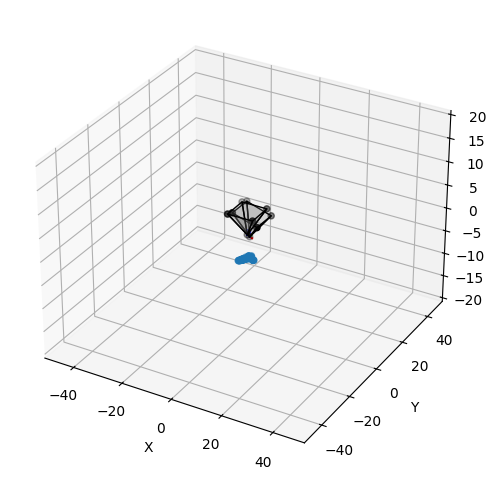

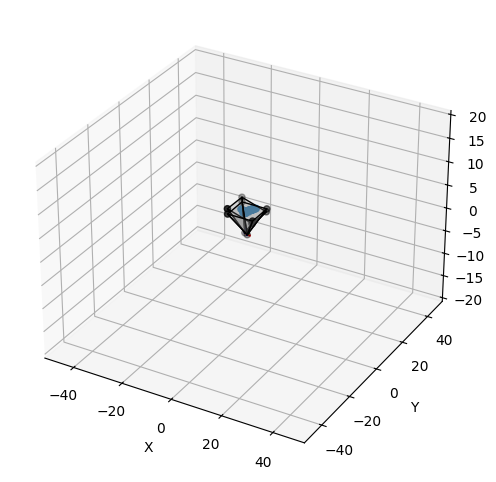

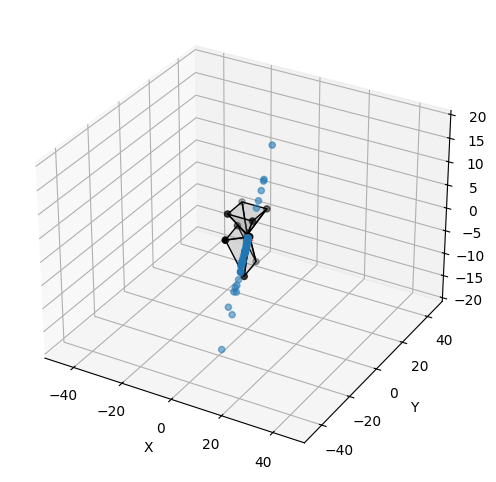

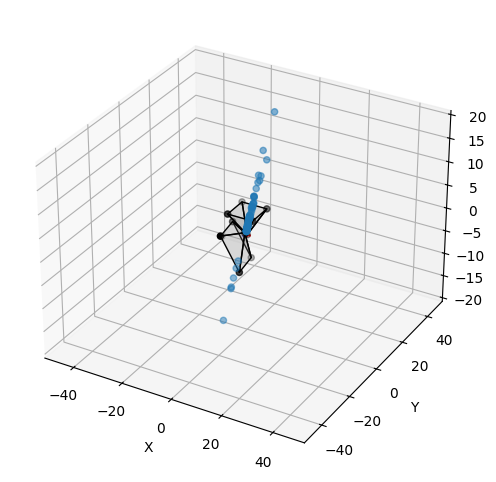

In [187]:
for cs in configSet: 
    fig = plt.figure(figsize=(9,6))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    ut.PlotCamera(np.eye(3,3),np.zeros((3,)),ax,scale=5,depth=5)
    ut.PlotCamera(cs[0],cs[1][:,0],ax,scale=5,depth=5)

    pts3d = cs[-1]
    ax.scatter3D(pts3d[:,0],pts3d[:,1],pts3d[:,2])

    ax.set_xlim(left=-50,right=50)
    ax.set_ylim(bottom=-50,top=50)
    ax.set_zlim(bottom=-20,top=20)

## 3.3. Camera Pose Disambiguation

In [188]:
_,R,t,mask2=cv2.recoverPose(E,img1pts[mask],img2pts[mask],K)
Rgt,tgt,count = sfmnp.DisambiguateCameraPose(configSet)

In [189]:
print (R)

print (Rgt)

print (t)

print (tgt) 

np.testing.assert_allclose(R,Rgt,rtol=1e-7,atol=1e-4)
np.testing.assert_allclose(t,tgt,rtol=1e-7,atol=1e-4)

[[ 0.98647006 -0.00523524 -0.16385791]
 [ 0.00337548  0.99992672 -0.01162622]
 [ 0.16390677  0.01091582  0.98641544]]
[[ 0.98647006 -0.00523524 -0.16385791]
 [ 0.00337548  0.99992672 -0.01162622]
 [ 0.16390677  0.01091582  0.98641544]]
[[ 0.95210822]
 [ 0.05260611]
 [-0.30120183]]
[[ 0.95210822]
 [ 0.05260611]
 [-0.30120183]]


## 3.4. Visualizing Point Cloud Output

Since point cloud isn't effectively viewed in matplotlib, we can use an external software `meshlab` for better visualizations. For that, we'd need to transform our 3D points' format into meshlab-compatible format. We understand it can be rather tedious, so the function `pts2ply()` is already implemented for you.

In [190]:
pts3d = GetTriangulatedPts(img1pts[mask],img2pts[mask],K,R,t,cv2.triangulatePoints)
ut.pts2ply(pts3d,'castle_2view.ply')


# 3. Reprojection Error: Evaluation

## 3.1. Computation

In [191]:
img1ptsReproj = sfmnp.ComputeReprojections(pts3d,np.eye(3,3),np.zeros((3,1)),K)
img2ptsReproj = sfmnp.ComputeReprojections(pts3d,R,t,K)

In [192]:
err2 = sfmnp.ComputeReprojectionError(img2pts[mask], img2ptsReproj)
err1 = sfmnp.ComputeReprojectionError(img1pts[mask], img1ptsReproj)

err1, err2 

(8.818973809300944, 9.241761070251894)

In [193]:
def compute_reprojection_error(pts3d, R1, t1, R2, t2, img1pts, img2pts, mask, K):
    img1ptsReproj = sfmnp.ComputeReprojections(pts3d,R1,t1,K)
    img2ptsReproj = sfmnp.ComputeReprojections(pts3d,R2,t2,K)

    err2 = sfmnp.ComputeReprojectionError(img2pts[mask], img2ptsReproj)
    err1 = sfmnp.ComputeReprojectionError(img1pts[mask], img1ptsReproj)

    return err1, err2 

## 3.2. Visualizations

[[2419.99609375 1226.76086426]
 [2246.00073242  498.15808105]
 [2312.23828125  804.46765137]
 [2216.63842773  684.02264404]
 [2425.98339844  686.0145874 ]
 [2407.74169922  990.76922607]
 [2268.47753906  775.60119629]
 [2620.39672852 1260.80615234]
 [1489.27746582  339.5944519 ]
 [2388.08325195  991.38446045]
 [2421.61987305 1151.1730957 ]
 [1508.32104492  344.26831055]
 [1736.18347168 1031.97424316]
 [2237.03881836  498.82330322]
 [1737.2019043  1032.16235352]
 [ 597.06622314  722.33544922]
 [2600.42138672 1007.08447266]
 [2040.32214355  325.09136963]
 [2309.52783203  859.32543945]
 [2644.58325195 1156.06213379]
 [1391.01367188  784.62695312]
 [2493.44067383  764.69970703]
 [2480.3190918   886.0927124 ]
 [2337.98999023  488.4866333 ]
 [1400.046875    789.49633789]
 [2259.87451172  953.41833496]
 [2495.54443359  765.11962891]
 [1874.02185059 1078.9786377 ]
 [2260.07080078  953.67633057]
 [2421.59716797 1150.84692383]
 [2438.75366211  776.40222168]
 [ 437.45306396  808.94128418]
 [2828.0

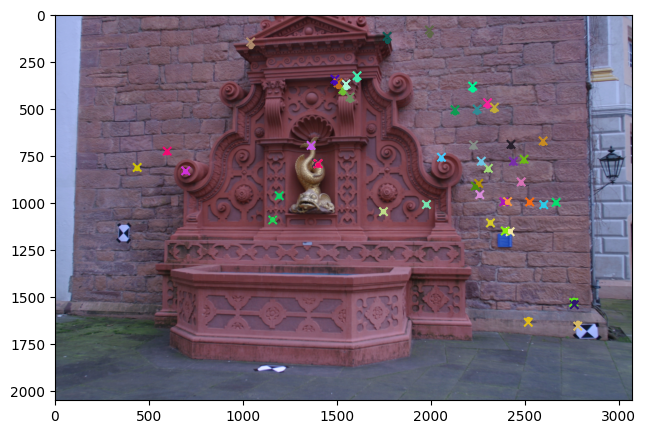

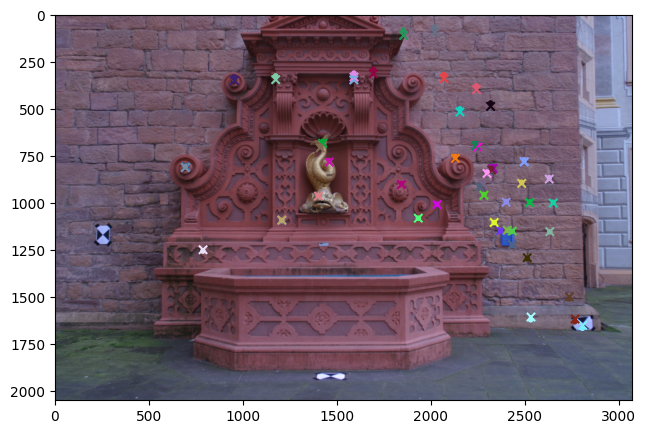

In [194]:

fig,ax=plt.subplots(figsize=(9,5))
ut.DrawCorrespondences(img1,img1pts[mask],img1ptsReproj,ax)

fig,ax=plt.subplots(figsize=(9,5))
ut.DrawCorrespondences(img2,img2pts[mask],img2ptsReproj,ax)

# 4. Perspective-n-Point Algorithm: New Camera Registration

## 4.0. Reading third image and 2D-3D Matching using SIFT

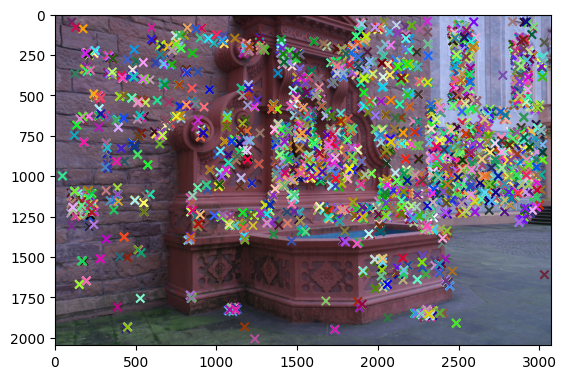

In [198]:
img3 = cv2.imread("../tutorial/data/fountain-P11/images/0008.jpg")
img3 = img3[:,:,::-1]
akaze= cv2.AKAZE_create()
kp3, desc3 = akaze.detectAndCompute(img3,None)

img3pts,pts3dpts = ut.Find2D3DMatches(desc1,img1idx,desc2,img2idx,desc3,kp3,mask,pts3d)

plt.imshow(img3, cmap='gray')
colors = colors=np.random.rand(len(img3pts),3)
plt.scatter(img3pts[:, 0], img3pts[:, 1],marker='x',c=colors)
plt.show()


## 4.1. Perspective-n-Point (PnP) Algorithm

### 4.1.1. Least Squares Solution

### 4.1.2. RANSAC

In [196]:


retval,Rvec,tnew,mask3gt = cv2.solvePnPRansac(pts3dpts,img3pts,K,None,confidence=.99,flags=cv2.SOLVEPNP_DLS)
if not retval: 
    raise Exception("PnP failed to converge")
Rnew,_=cv2.Rodrigues(Rvec)


print(ret)
print(Rnew)

Exception: PnP failed to converge

In [ ]:
#Rnew,tnew,mask3=sfmnp.LinearPnPRansac(pts3dpts,img3pts,K,outlierThres=5.0,iters=2000)

## 4.2. Visualizations

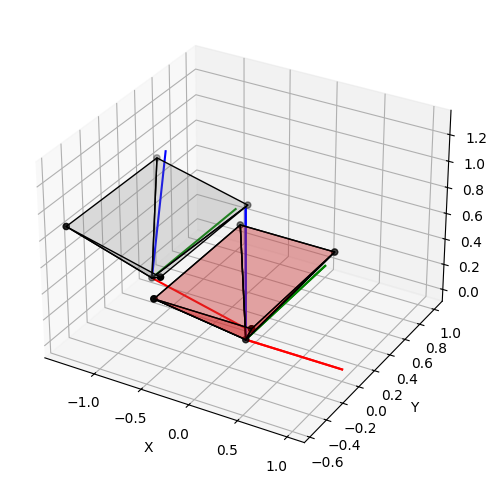

In [ ]:
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')



ut.PlotCamera(np.eye(3,3),np.zeros((3,)),ax)
ut.PlotCamera(R,t[:,0],ax)
ut.PlotCamera(Rnew,tnew[:,0],ax,faceColor='red')

# 5. Re-triangulation

In [ ]:
tnew = tnew[:,0]
kpNew, descNew = kp3, desc3 

kpOld,descOld = kp1,desc1
ROld, tOld = np.eye(3), np.zeros((3,1))

accPts = []
for (ROld, tOld, kpOld, descOld) in [(np.eye(3),np.zeros((3,1)), kp1,desc1),(R,t,kp2,desc2)]: 
    
    #Matching between old view and newly registered view.. 
    print ('[Info]: Feature Matching..')
    matcher = cv2.BFMatcher(crossCheck=True)
    matches = matcher.match(descOld, desc3)
    matches = sorted(matches, key = lambda x:x.distance)
    imgOldPts, imgNewPts, _, _ = ut.GetAlignedMatchesAKAZE(kpOld,kpNew,matches)
    
    #Pruning the matches using fundamental matrix..
    print ('[Info]: Pruning the Matches..')
    F,mask=cv2.findFundamentalMat(imgOldPts,imgNewPts,method=cv2.FM_RANSAC, ransacReprojThreshold=0.1, confidence=0.99)
    mask = mask.flatten().astype(bool)
    imgOldPts=imgOldPts[mask]
    imgNewPts=imgNewPts[mask]
    
    #Triangulating new points
    print ('[Info]: Triangulating..')
    
    newPts = sfmnp.GetTriangulatedPts(imgOldPts,imgNewPts, K, Rnew,tnew[:,np.newaxis],cv2.triangulatePoints,ROld,tOld)
    
    #Adding newly triangulated points to the collection
    accPts.append(newPts)

[Info]: Feature Matching..
[Info]: Pruning the Matches..
[Info]: Triangulating..
(3, 3) (3, 1) (3, 3) (3, 1)
[Info]: Feature Matching..
[Info]: Pruning the Matches..
[Info]: Triangulating..
(3, 3) (3, 1) (3, 3) (3, 1)


In [ ]:
#Adding the original 2-view-sfm point cloud and saving the whole collection
accPts.append(pts3d)
ut.pts2ply(np.concatenate((accPts),axis=0),'castle_nview.ply')

# 6. Final Result 

<img src="fountain_dense.png">

# Chapter 4. Putting It Together: Part I

# Chapter 5. Bundle Adjustment

# Chapter 6. Putting It Together: Part II